In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm
from pygam import PoissonGAM, s

In [2]:
df = pd.read_csv("PHILIPPINES_DATA_19.csv")
print("Shape:", df.shape)
display(df.head())

Shape: (10602, 70)


,FinalWgt,CR1,CR2,PHR3,PHR4,PHR5,CR5,CR6,CR7,CR8,...,CR42,CR43,OR48,OR49,PHR64,OR54,OR55,PHR67,Stratum,PSU
0,1001.339285,5.0,2.0,4.0,1.0,NaN,1.0,6.0,1.0,1.0,...,2.0,2.0,NaN,NaN,2.0,1.0,1.0,1.0,201901001,1
1,1001.339285,5.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,...,1.0,5.0,3.0,2.0,1.0,1.0,1.0,1.0,201901001,1
2,1001.339285,5.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,...,3.0,5.0,3.0,2.0,1.0,1.0,1.0,1.0,201901001,1
3,1001.339285,5.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,...,2.0,4.0,2.0,2.0,1.0,2.0,1.0,1.0,201901001,1
4,1001.339285,5.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,...,3.0,5.0,3.0,2.0,1.0,2.0,1.0,2.0,201901001,1


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FinalWgt,10042.0,7.314186e+02,430.959049,2.229719e+02,4.044910e+02,5.389617e+02,1.114482e+03,5.456262e+03
CR1,10024.0,3.915104e+00,1.503422,1.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,7.000000e+00
CR2,10042.0,5.507867e-01,0.501824,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
PHR3,10042.0,1.441546e+00,1.126683,-1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00
PHR4,9993.0,1.183929e+00,0.387445,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
...,...,...,...,...,...,...,...,...
OR55,9819.0,1.272125e+00,0.445077,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
PHR67,9848.0,1.337734e+00,0.472961,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
Stratum,10042.0,2.019020e+08,822.845138,2.019010e+08,2.019010e+08,2.019020e+08,2.019030e+08,2.019030e+08
PSU,10042.0,1.497341e+01,8.599847,1.000000e+00,8.000000e+00,1.500000e+01,2.200000e+01,3.200000e+01


In [18]:
df = df.replace([" ", "NA", "N/A", "NaN"], np.nan)
df = df.dropna(subset=["CR7"])  # drop rows missing target

df["CR7"] = pd.to_numeric(df["CR7"], errors="coerce")
df = df[df["CR7"].between(1, 7)]
df['CR2'] = df['CR2'].astype('category').cat.codes
df['PHR3'] = df['PHR3'].astype('category').cat.codes

# Recode outcome
df["Smoking_Status"] = df["CR7"].apply(lambda x: 0 if x == 1 else 1)

Smoking Status Frequency:


Smoking_Status
0    9019
1    1023
Name: count, dtype: int64

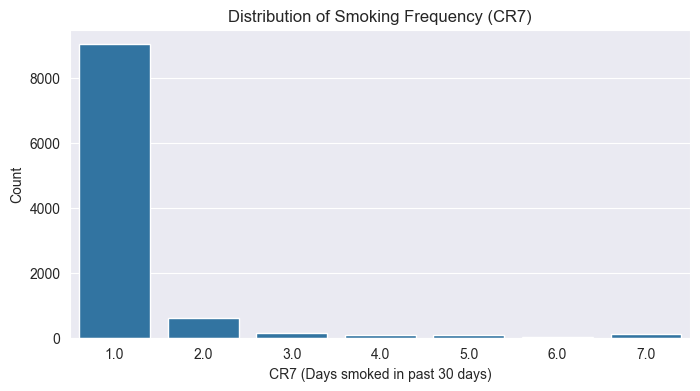

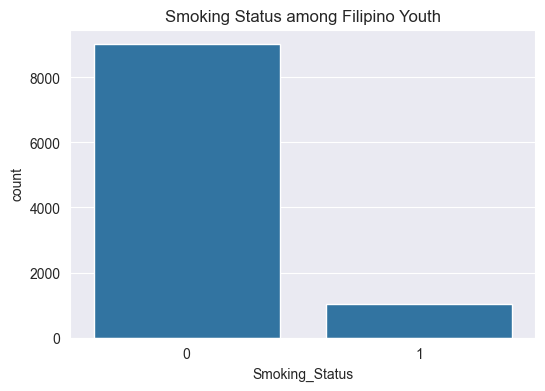

In [19]:
print("Smoking Status Frequency:")
display(df["Smoking_Status"].value_counts())

plt.figure(figsize=(8, 4))
sns.countplot(x="CR7", data=df)
plt.title("Distribution of Smoking Frequency (CR7)")
plt.xlabel("CR7 (Days smoked in past 30 days)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="Smoking_Status", data=df)
plt.title("Smoking Status among Filipino Youth")
plt.show()

In [20]:
predictors = [
    "CR1",   # Age
    "CR2",   # Sex
    "PHR3",  # Grade
    "PHR4",  # School type
    "CR5",   # Tried smoking
    "CR9",   # Tried other tobacco
    "PHR20", # Tried vape
    "CR39",  # Friends offered tobacco
    "CR41",  # Difficulty quitting
    "PHR31", # Smoking allowed at home
    "PHR44"  # See cigarettes sold near school
]

# Keep only existing columns
predictors = [p for p in predictors if p in df.columns]
df_model = df.dropna(subset=predictors + ["CR7"])

In [26]:
print("\n--- GLM MODEL ---")
formula = "CR7 ~ " + " + ".join(predictors)
glm_model = glm(formula=formula, data=df_model, family=sm.families.Poisson()).fit()
print(glm_model.summary())



--- GLM MODEL ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CR7   No. Observations:                 8725
Model:                            GLM   Df Residuals:                     8713
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9694.5
Date:                Fri, 24 Oct 2025   Deviance:                       1252.1
Time:                        14:31:08   Pearson chi2:                 1.54e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1187
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1487      0.110 

In [22]:
print("\n--- GAM MODEL ---")
X = df_model[predictors].select_dtypes(include=[np.number]).fillna(0)
y = df_model["CR7"]

gam = PoissonGAM(s(0) + s(1) + s(2) + s(3) + s(4), fit_intercept=True).fit(X, y)

print("\n GAM pseudo R²:", gam.statistics_['pseudo_r2'])
print("\n GAM AIC:", gam.statistics_['AIC'])


--- GAM MODEL ---


C:\Users\acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygam\pygam.py:2858: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = y.ravel()



 GAM pseudo R²: OrderedDict({'explained_deviance': np.float64(0.41051734757454106), 'McFadden': np.float64(0.9528245733965046), 'McFadden_adj': np.float64(0.04571162244956095)})

 GAM AIC: 19555.103896777167


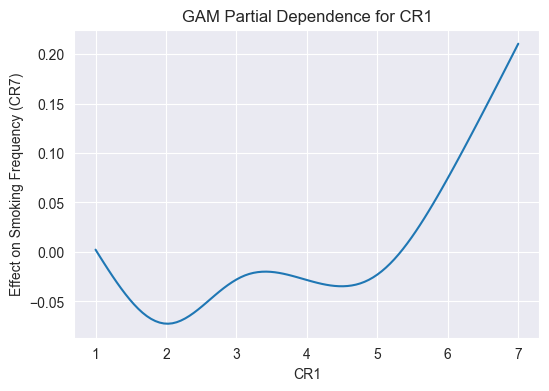

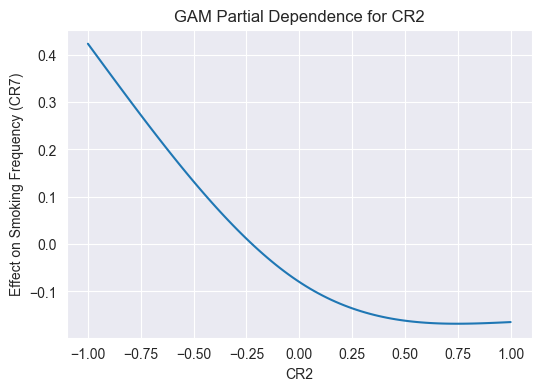

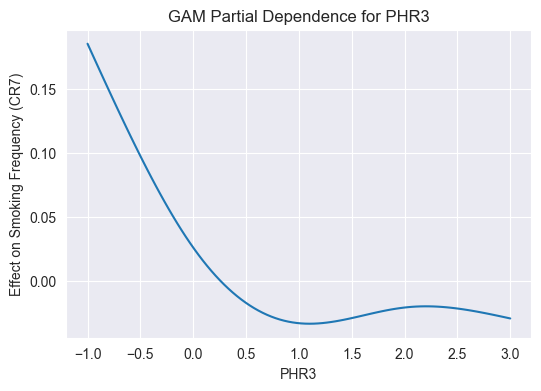

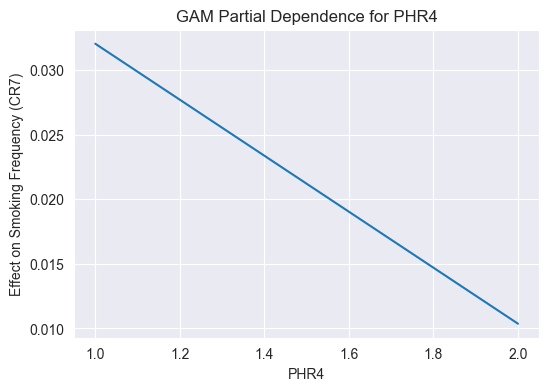

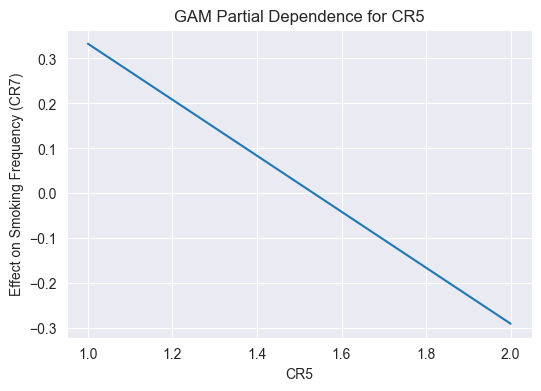

In [34]:
for i, col in enumerate(X.columns[:5]):
    plt.figure(figsize=(6, 4))
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"GAM Partial Dependence for {col}")
    plt.xlabel(col)
    plt.ylabel("Effect on Smoking Frequency (CR7)")
    plt.show()

In [24]:
print("\n--- Model Comparison ---")
print("GLM AIC:", glm_model.aic)
print("GAM AIC:", gam.statistics_['AIC'])
if gam.statistics_['AIC'] < glm_model.aic:
    print("→ GAM fits better (nonlinear effects present).")
else:
    print("→ GLM fits comparably (mostly linear effects).")


--- Model Comparison ---
GLM AIC: 19413.07237389254
GAM AIC: 19555.103896777167
→ GLM fits comparably (mostly linear effects).


In [29]:
print('Model Difference')
print(gam.statistics_['AIC']-glm_model.aic)

Model Difference
142.0315228846266
